[Presentation about the data set](https://owncloud.gwdg.de/index.php/s/UbtiPjeG2guFMk7)

In [1]:
import sys
!{sys.executable} -m pip install --upgrade gribscan

## Acceess the Monsoon 2.0 intake catalog

In [2]:
%matplotlib inline
import intake


cat_yaml = "/work/bd1154/highresmonsoon/experiments/monsoon2.yaml"
cat = intake.open_catalog(cat_yaml)

print("Available Monsoon 2.0 runs:", *list(cat))

Available Monsoon 2.0 runs: luk1000 luk1001 luk1002 luk1003 luk1010 luk1011 luk1020 luk1021 luk1022 luk1023 luk1030 luk1031 luk1103 luk1123 luk2000 grids


In [3]:
data = cat["luk1001"].to_dask()
data

## Plotting timeseries

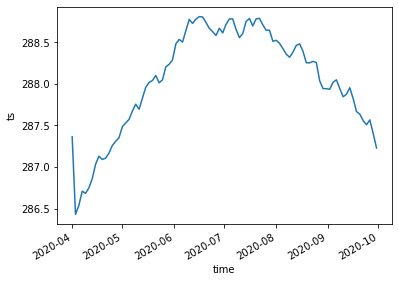

In [4]:
data.ts.isel(time=slice(1, None, 96)).mean("cell").plot()

### Loop over catalog entries

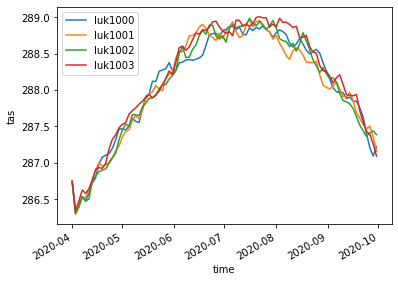

In [5]:
import matplotlib.pyplot as plt


for ens_member in cat.search("luk100"):
    data = cat[ens_member].to_dask()
    data.tas.isel(time=slice(1, None, 96)).mean("cell").plot(label=ens_member)
plt.legend()

## Efficient scatter plot using datashader

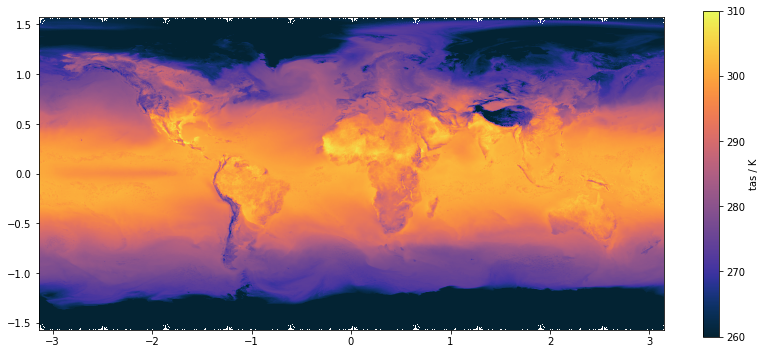

In [6]:
import cmocean
import datashader as ds
from datashader.mpl_ext import dsshow


data = cat["luk1001"].to_dask()
grid = cat.grids[data.uuidOfHGrid].to_dask()
dwg = data.merge(grid)

fig, ax = plt.subplots(figsize=(14, 6))
artist = ds.mpl_ext.dsshow(
    dwg[["clon", "clat", "tas"]].isel(time=48 * 30),
    ds.Point("clon", "clat"),
    aggregator=ds.mean("tas"),
    cmap=cmocean.cm.thermal,
    vmin=260,
    vmax=310,
    ax=ax,
)
fig.colorbar(artist, label=f"tas / K")

### Scatter plot with map projection

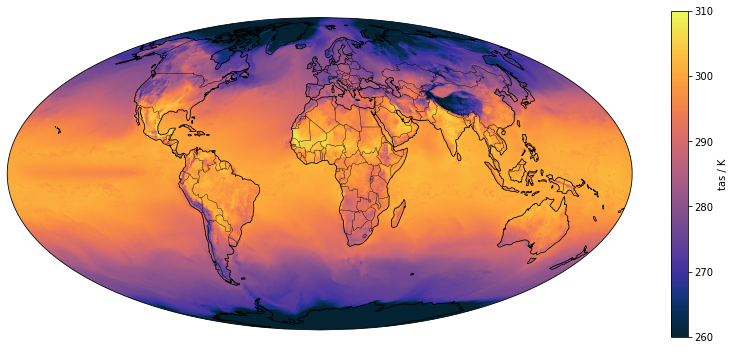

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd


projection = ccrs.Mollweide()
coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon),
    np.rad2deg(grid.clat),
)

fig, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": projection})
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
artist = dsshow(
    pd.DataFrame({
        "val": data["tas"].isel(time=48 * 30).values,
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    ds.Point('x', 'y'),
    ds.mean('val'),
    vmin=260,
    vmax=310,
    cmap=cmocean.cm.thermal,
    ax=ax,
)
fig.colorbar(artist, label="tas / K")

## Calculate zonal means
Calculate the zonal-mean on the native ICON grid by
1. counting all cells in a latitude bin
2. calculate the sum over all values of a variable in a latitude bin

(-1.413716694115407, 1.413716694115407)

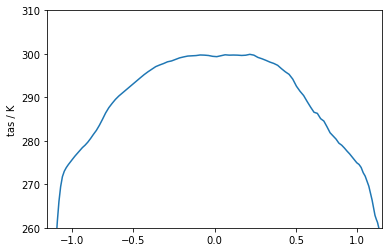

In [8]:
counts_per_bin, lat_bins = np.histogram(dwg.clat, bins=128, range=(-np.pi / 2, np.pi / 2))
varsum_per_bin, _ = np.histogram(dwg.clat, weights=dwg["tas"].isel(time=48*30), bins=lat_bins)

fig, ax = plt.subplots()
ax.plot(0.5 * (lat_bins[1:] + lat_bins[:-1]), varsum_per_bin / counts_per_bin)
ax.set_ylabel("tas / K")
ax.set_ylim(260, 310)
# Scale the x-axis to weight by the area of different latitudes
ax.set_xscale("function", functions=(lambda d: np.sin(d), lambda d: np.arcsin(d)))
ax.set_xlim(0.9 * lat_bins.min(), 0.9 * lat_bins.max())